In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import matplotlib
from dataclasses import replace
import time
from datetime import datetime
import pandas as pd
import nlopt
import copy

In [2]:
import sys
sys.path.append('/home/gridsan/wmichaels/xray_coherence')

from src.simparams import SimParams
from src.threshold_opt import threshold_opt, x_I_opt
from src.forwardmodels import forward_model_focus_plane_wave_power, field_z_arbg_z, forward_model_focus_point_source_power
from src.elements import ArbitraryElement, ZonePlate
from src.propagation import propagate_z
from src.sources import plane_wave, incoherent_source
from src.util import kramers_law_weights, create_material_map, refractive_index_at_wvl, quasi_monochromatic_spectrum
from src.inversedesign_utils import heaviside_projection, zp_init

In [3]:
matplotlib.rcParams['figure.dpi'] = 140
matplotlib.rcParams.update({'font.size': 15})

In [4]:
print(f"cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

cuda available: True
Using device: cuda


# Standard values
## These are values used consistently across sweeps while another variable is being changed. 

In [5]:
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512


In [6]:
Nwvl = 5
Vp = 30e3
emin = 1e3
rsrc = 50e-6
zsrc = 10e-3
Nmodes = 200
sparse_tol = 5e-2
filter_thickness = 0.5e-6
filter_material = 'w'
Vcenter = 8e3
bandwidth = 0.01
delta = 1e-6
beta = 1e-7
thickness = 250e-9
z = 10e-3
Nx = 2**17
dx = 1e-9
Wcenter = 16e-9
designx = 16e-9
n = int(designx // dx) # number of simulation pixels within one design pixel
Wzero = 128e-9
max_eval_std = 10
max_inner_eval_std = 10
method = nlopt.LD_MMA
betas_std = list(np.logspace(0, 2.5, 5))

lams_std, weights_std = kramers_law_weights(
    e_min = emin, 
    e_max = Vp, 
    N = Nwvl, 
    filter_weights = True, 
    filter_thickness = filter_thickness,
    filter_material = filter_material,
    uniform_energy = True, 
    device = device
)

# lams_std, weights_std = quasi_monochromatic_spectrum(
#     central_energy_ev = Vcenter, 
#     N = Nwvl, 
#     bandwidth = bandwidth, 
#     device = device
# )

sim_params_std = SimParams(
    Ny=1, 
    Nx=Nx, 
    dx=dx,
    device=device, 
    dtype = torch.complex64,
    lams=lams_std, 
    weights=weights_std
    )

modes, evals = incoherent_source(sim_params = sim_params_std, rsrc = rsrc, z = zsrc, N = Nmodes, sparse_tol = sparse_tol)

finished lam 1 of 5
finished lam 2 of 5
finished lam 3 of 5
finished lam 4 of 5
finished lam 5 of 5


In [7]:
pow_modes = modes.transpose(0, 1)
pow_evals = evals.transpose(0, 1)

# Calculate intensity array and delete output_modes
P_in = torch.sum(pow_modes.abs().pow(2)*(pow_evals.unsqueeze(-1).unsqueeze(-1)), dim=1).sum().real

Ncenter = Wcenter / sim_params_std.dx
Nzero = int(Wzero / (sim_params_std.dx * n))

au_map = create_material_map("au")
uniform_map = [np.array([8e-12, 8e-2]), np.array([1 - delta + 1j*beta, 1 - delta + 1j*beta])]
# elem_ind = refractive_index_at_wvl(5e-11, au_map)

x_init = torch.rand(sim_params_std.Nx // n // 2).cpu().numpy()
x_init[x_init.shape[0]-Nzero:] = 0

forward_model = forward_model_focus_plane_wave_power
forward_model = forward_model_focus_point_source_power

elem_params_std = {
    "thickness": thickness, 
    "elem_map": au_map,
    "gap_map": [np.array([8e-12, 8e-2]), np.array([1., 1.])]
}

opt_params_std = {
    "method": method,
    "n": n, 
    "betas": betas_std,
    "max_eval": max_eval_std, 
    "inner_maxeval": max_inner_eval_std, 
    "x_init": x_init, 
    "forward_model": forward_model
}

args_std = (elem_params_std, int(Ncenter), z)
args_std = (elem_params_std, int(Ncenter), z, modes, evals)

# x_init = zp_init(
#     lam = sim_params_std.lams[torch.argmax(sim_params_std.weights)], 
#     f = z, 
#     min_feature_size = sim_params_std.dx * opt_params_std["n"], 
#     sim_params = sim_params_std, 
#     opt_params = opt_params_std
# )

design_dict_std = {
    "sim_params": sim_params_std,
    "elem_params": elem_params_std,
    "opt_params": opt_params_std,
    "args": args_std,
    "P_in": P_in
}

In [8]:
P_in

tensor(999.2532, device='cuda:0')

In [9]:
print(modes.shape)

torch.Size([200, 5, 1, 131072])


In [10]:
print(evals.shape)

torch.Size([200, 5])


In [11]:
n

16

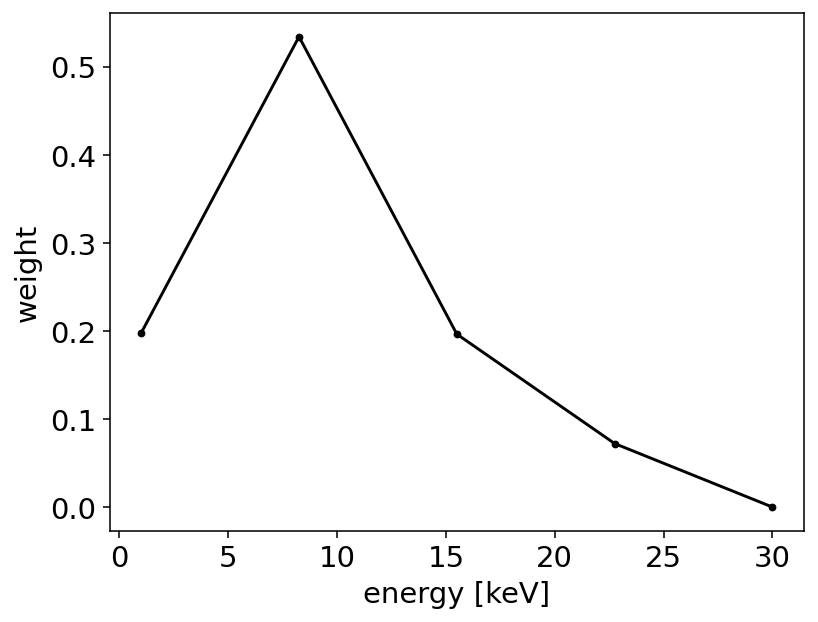

In [12]:
h = 4.135667696e-15 # eV s
c = 299792458 # m/s
energies_std = h * c / lams_std

plt.plot(energies_std.cpu()/1e3, weights_std.cpu(), color="black", marker=".")
plt.xlabel("energy [keV]")
plt.ylabel("weight")
plt.show()

# Timing of single forward model iteration

In [13]:
ndof = int(sim_params_std.Nx / opt_params_std["n"] // 2)

In [14]:
x_init

array([0.8677044 , 0.08594865, 0.2511592 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [15]:
%%timeit
forward_model(
    torch.tensor(x_init), 
    sim_params_std, 
    opt_params_std, 
    *args_std
)

332 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Simulation parameters

In [16]:
print("simulation domain width [mm]")
sim_params_std.dx * sim_params_std.Nx * 1e3

simulation domain width [mm]


0.13107200000000002

In [17]:
print("opt dof")
int(sim_params_std.Nx / opt_params_std["n"] // 2)

opt dof


4096

In [18]:
print("min feature size [nm]")
sim_params_std.dx * opt_params_std["n"] * 1e9

min feature size [nm]


16.0

# Sweep functions

In [19]:
def threshold_opt_sweep(design_dicts):
    opt_xs = []
    opt_x_fulls = []
    opt_Is = []
    opt_objs = []
    start_time = time.time()
    for i, design_dict in enumerate(design_dicts):
        opt_x, opt_x_full, opt_I, opt_obj = x_I_opt(design_dict)
        
        opt_xs.append(opt_x)
        opt_x_fulls.append(opt_x_full)
        opt_Is.append(opt_I)
        opt_objs.append(opt_obj)
        
        curr_time = time.time()
        print(f"finished design dict {i}")
        print(f"time elapsed: {round(curr_time - start_time)} s")
        print("----------------------------------")
        
    return opt_xs, opt_x_fulls, opt_Is, opt_objs

In [20]:
def threshold_opt_iterative(design_dicts):
    opt_xs = []
    opt_x_fulls = []
    opt_Is = []
    opt_objs = []
    start_time = time.time()
    for i, design_dict in enumerate(design_dicts):
        
        if i == 0:
            opt_x, opt_x_full, opt_I, opt_obj = x_I_opt(design_dict)
        else: 
            design_dict_diffx = copy.deepcopy(design_dict) 
            design_dict_diffx["x_init"] = opt_xs[-1]
            opt_x, opt_x_full, opt_I, opt_obj = x_I_opt(design_dict)
        
        opt_xs.append(opt_x)
        opt_x_fulls.append(opt_x_full)
        opt_Is.append(opt_I)
        opt_objs.append(opt_obj)
        del opt_x
        del opt_x_full
        del opt_I
        del opt_obj
        
        curr_time = time.time()
        print(f"finished design dict {i}")
        print(f"time elapsed: {round(curr_time - start_time)} s")
        print("----------------------------------")
        
    return opt_xs, opt_x_fulls, opt_Is, opt_objs

In [21]:
def get_formatted_datetime():
    now = datetime.now()
    formatted_datetime = now.strftime("%Y-%m-%d %H.%M.%S")
    return formatted_datetime

In [22]:
def threshold_opt_sweep_save(design_dicts, sweep_func, path_string=""):
    opt_xs, opt_x_fulls, opt_Is, opt_objs = sweep_func(design_dicts)
    end_time = get_formatted_datetime()

    if path_string == "":
        path_id = end_time
    else:
        path_id = path_string + end_time
    
    for arr, string in zip([opt_xs, opt_x_fulls, opt_Is, opt_objs], ["xs", "x_fulls", "Is", "objs"]):
        file_path = f'/home/gridsan/wmichaels/opt_out/{path_id}_{string}'
            # np.save(file_path, arr, allow_pickle=True)
        np.savez(file_path, *arr)
    
    dict_file_path = f'/home/gridsan/wmichaels/opt_out/{path_id}_dict'
    np.save(dict_file_path, design_dicts)

# Method

In [78]:
methods = [nlopt.LD_MMA, nlopt.LD_CCSAQ]
design_dicts = []
for method in methods:
    design_dict = copy.deepcopy(design_dict_std) 
    design_dict["opt_params"]["method"] = method
    design_dicts.append(design_dict)

In [79]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "method_incoh")

finished design dict 0
time elapsed: 55 s
----------------------------------
finished design dict 1
time elapsed: 116 s
----------------------------------


# Filter

In [33]:
filtered = [False, True]
design_dicts = []

for fil in filtered:
    design_dict = copy.deepcopy(design_dict_std)

    lams, weights = kramers_law_weights(
        e_min = emin, 
        e_max = Vp, 
        N = Nwvl, 
        filter_weights = fil, 
        filter_thickness = filter_thickness,
        filter_material = filter_material,
        uniform_energy = True, 
        device = device
    )
    
    sim_params = SimParams(
        Ny=1, 
        Nx=sim_params_std.Nx, 
        dx=dx,
        device=device, 
        dtype=torch.complex64,
        lams=lams, 
        weights=weights
        )
    design_dict["sim_params"] = sim_params
    design_dicts.append(design_dict)

In [34]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "filter_comp_tungsten")

finished design dict 0
time elapsed: 9 s
----------------------------------
finished design dict 1
time elapsed: 18 s
----------------------------------


# Max eval per stage

In [39]:
max_evals = [10, 20, 50, 100]
design_dicts = []
for max_eval in max_evals:
    design_dict = copy.deepcopy(design_dict_std) 
    design_dict["opt_params"]["max_eval"] = max_eval
    design_dicts.append(design_dict)

In [40]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "max_eval_incoh")

finished design dict 0
time elapsed: 55 s
----------------------------------
finished design dict 1
time elapsed: 162 s
----------------------------------
finished design dict 2
time elapsed: 423 s
----------------------------------
finished design dict 3
time elapsed: 980 s
----------------------------------


# Max inner eval per stage

In [42]:
inner_max_evals = [2, 5, 10, 20, 50]
design_dicts = []
for inner_max_eval in inner_max_evals:
    design_dict = copy.deepcopy(design_dict_std) 
    design_dict["opt_params"]["inner_maxeval"] = inner_max_eval
    design_dicts.append(design_dict)

In [43]:
torch.cuda.empty_cache()
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "inner_max_eval_incoh")

finished design dict 0
time elapsed: 66 s
----------------------------------
finished design dict 1
time elapsed: 134 s
----------------------------------
finished design dict 2
time elapsed: 203 s
----------------------------------
finished design dict 3
time elapsed: 268 s
----------------------------------
finished design dict 4
time elapsed: 334 s
----------------------------------


# Beta schedule

In [85]:
np.logspace(0, 2.5, 1)

array([1.])

In [86]:
bmaxes = [1, 2, 2.5, 3]
nums = [1, 2, 3, 4, 5]

beta_schedules = [
    list(np.logspace(0, 2.5, num)) for num in nums
]

design_dicts = []
for beta_s in beta_schedules:
    design_dict = copy.deepcopy(design_dict_std) 
    design_dict["opt_params"]["betas"] = beta_s
    design_dicts.append(design_dict)

In [87]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "beta_schedule_num")

finished design dict 0
time elapsed: 2 s
----------------------------------
finished design dict 1
time elapsed: 6 s
----------------------------------
finished design dict 2
time elapsed: 12 s
----------------------------------
finished design dict 3
time elapsed: 19 s
----------------------------------
finished design dict 4
time elapsed: 29 s
----------------------------------


# Simulation spacing

In [31]:
dxs = [1e-9, 2e-9, 4e-9]

design_dicts = []
for dxi in dxs:
    design_dict = copy.deepcopy(design_dict_std)
    sim_params = SimParams(
        Ny=1, 
        Nx=Nx, 
        dx=dxi,
        device=device, 
        dtype=torch.complex64,
        lams=lams_std, 
        weights=weights_std
        )

    n = int(designx / dxi)

    x_init = torch.rand(sim_params.Nx // n // 2).cpu().numpy()
    x_init[x_init.shape[0]-Nzero:] = 0
    
    design_dict["sim_params"] = sim_params
    design_dict["opt_params"]["n"] = n
    design_dict["opt_params"]["x_init"] = x_init
    design_dicts.append(design_dict)

In [32]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "dx_sweep")

finished design dict 0
time elapsed: 186 s
----------------------------------
finished design dict 1
time elapsed: 385 s
----------------------------------
finished design dict 2
time elapsed: 610 s
----------------------------------


# Thickness

In [80]:
thicknesses = np.array([0.05, 0.1, 0.25, 0.5, 1.0, 2.0])*1e-6
design_dicts = []
for t in thicknesses:
    design_dict = copy.deepcopy(design_dict_std) 
    design_dict["elem_params"]["thickness"] = t
    design_dicts.append(design_dict)

In [81]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "thickness_incoh")

finished design dict 0
time elapsed: 62 s
----------------------------------
finished design dict 1
time elapsed: 124 s
----------------------------------
finished design dict 2
time elapsed: 186 s
----------------------------------
finished design dict 3
time elapsed: 248 s
----------------------------------
finished design dict 4
time elapsed: 305 s
----------------------------------
finished design dict 5
time elapsed: 360 s
----------------------------------


# Simulation width

In [50]:
widths = [2**20, 2**21, 2**22, 2**23, 2**24]

design_dicts = []
for w in widths:
    design_dict = copy.deepcopy(design_dict_std)
    sim_params = SimParams(
        Ny=1, 
        Nx=w, 
        dx=dx,
        device=device, 
        dtype=torch.complex64,
        lams=lams_std, 
        weights=weights_std
        )

    x_init = torch.rand(sim_params.Nx // opt_params_std["n"] // 2).cpu().numpy()
    x_init[x_init.shape[0]-Nzero:] = 0
    
    design_dict["sim_params"] = sim_params
    design_dict["x_init"] = x_init
    design_dicts.append(design_dict)

In [51]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "sim_width")

finished design dict 0
time elapsed: 3 s
----------------------------------
finished design dict 1
time elapsed: 9 s
----------------------------------
finished design dict 2
time elapsed: 18 s
----------------------------------
finished design dict 3
time elapsed: 36 s
----------------------------------
finished design dict 4
time elapsed: 70 s
----------------------------------


# Width of element

In [52]:
facs = [4, 2, 1]

design_dicts = []
for fac in facs:
    design_dict = copy.deepcopy(design_dict_std)

    x_init = torch.rand(sim_params_std.Nx // opt_params_std["n"] // 2).cpu().numpy()[::fac]
    x_init[x_init.shape[0]-Nzero:] = 0
    
    design_dict["opt_params"]["x_init"] = x_init
    design_dicts.append(design_dict)

In [53]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "elem_width")

finished design dict 0
time elapsed: 9 s
----------------------------------
finished design dict 1
time elapsed: 17 s
----------------------------------
finished design dict 2
time elapsed: 27 s
----------------------------------


# Center width

In [25]:
center_widths = np.array([8, 16, 32, 256, 1024])*1e-9

design_dicts = []
for c_width in center_widths:

    Ncenter = c_width / sim_params_std.dx

    args = (elem_params_std, int(Ncenter), z, modes, evals)

    design_dict = copy.deepcopy(design_dict_std)
    design_dict["args"] = args
    
    design_dicts.append(design_dict)

In [26]:
torch.cuda.empty_cache()
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "center_width_incoh")

finished design dict 0
time elapsed: 55 s
----------------------------------
finished design dict 1
time elapsed: 110 s
----------------------------------
finished design dict 2
time elapsed: 165 s
----------------------------------
finished design dict 3
time elapsed: 219 s
----------------------------------
finished design dict 4
time elapsed: 274 s
----------------------------------


# Focal length

In [89]:
focal_lengths = np.array([0.1, 1, 5, 10, 50, 100])*1e-3

design_dicts = []
for f in focal_lengths:

    args = (elem_params_std, int(Ncenter), f, modes, evals)
    
    design_dict = copy.deepcopy(design_dict_std)

    design_dict["args"] = args
    
    design_dicts.append(design_dict)

In [90]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "focal_length_incoh")

finished design dict 0
time elapsed: 60 s
----------------------------------
finished design dict 1
time elapsed: 119 s
----------------------------------
finished design dict 2
time elapsed: 174 s
----------------------------------
finished design dict 3
time elapsed: 228 s
----------------------------------
finished design dict 4
time elapsed: 283 s
----------------------------------
finished design dict 5
time elapsed: 338 s
----------------------------------


# Min feature size

In [43]:
ns = [4, 8, 16, 32, 64, 128, 256]
design_dicts = []

for n in ns:
    design_dict = copy.deepcopy(design_dict_std) 
    design_dict["opt_params"]["n"] = n

    Ncenter = n
    args = (elem_params_std, int(Ncenter), z)

    design_dict["args"] = args
    
    design_dicts.append(design_dict)

In [44]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "min_feature_size")

finished design dict 0
time elapsed: 9 s
----------------------------------
finished design dict 1
time elapsed: 18 s
----------------------------------
finished design dict 2
time elapsed: 27 s
----------------------------------
finished design dict 3
time elapsed: 37 s
----------------------------------
finished design dict 4
time elapsed: 48 s
----------------------------------
finished design dict 5
time elapsed: 60 s
----------------------------------
finished design dict 6
time elapsed: 77 s
----------------------------------


# Intitial guess zero width

In [60]:
Wzeros

array([0.00e+00, 1.60e-08, 3.20e-08, 6.40e-08, 1.28e-07, 2.56e-07,
       5.12e-07])

In [61]:
Wzeros = np.array([0, 16, 32, 64, 128, 256, 512])*1e-9
design_dicts = []

for Wz in Wzeros:
    design_dict = copy.deepcopy(design_dict_std) 
    
    Nz = int(Wz / (sim_params_std.dx * n))
    print(Nz)
    x_init = torch.rand(sim_params_std.Nx // n // 2).cpu().numpy()
    x_init[x_init.shape[0]-Nz:] = 0

    design_dict["opt_params"]["x_init"] = x_init

    design_dicts.append(design_dict)

0
1
2
4
8
16
32


In [45]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "x_init_zero")

finished design dict 0
time elapsed: 11 s
----------------------------------
finished design dict 1
time elapsed: 23 s
----------------------------------
finished design dict 2
time elapsed: 34 s
----------------------------------
finished design dict 3
time elapsed: 46 s
----------------------------------
finished design dict 4
time elapsed: 58 s
----------------------------------
finished design dict 5
time elapsed: 69 s
----------------------------------
finished design dict 6
time elapsed: 80 s
----------------------------------


# Number of wavelengths

In [59]:
Nwvls = [5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50]

design_dicts = []
for Nwvl in Nwvls:
    design_dict = copy.deepcopy(design_dict_std)

    lams, weights = kramers_law_weights(
        e_min = emin, 
        e_max = Vp, 
        N = Nwvl, 
        filter_weights = True,
        filter_thickness = filter_thickness, 
        filter_material = filter_material,
        uniform_energy = True, 
        device = device
    )
    
    sim_params = SimParams(
        Ny=1, 
        Nx=sim_params_std.Nx, 
        dx=dx,
        device=device, 
        dtype=torch.complex64,
        lams=lams, 
        weights=weights
        )
    design_dict["sim_params"] = sim_params
    design_dicts.append(design_dict)

In [60]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "Nwvl")

finished design dict 0
time elapsed: 4 s
----------------------------------
finished design dict 1
time elapsed: 9 s
----------------------------------
finished design dict 2
time elapsed: 14 s
----------------------------------
finished design dict 3
time elapsed: 20 s
----------------------------------
finished design dict 4
time elapsed: 26 s
----------------------------------
finished design dict 5
time elapsed: 33 s
----------------------------------
finished design dict 6
time elapsed: 41 s
----------------------------------
finished design dict 7
time elapsed: 50 s
----------------------------------
finished design dict 8
time elapsed: 63 s
----------------------------------
finished design dict 9
time elapsed: 80 s
----------------------------------
finished design dict 10
time elapsed: 103 s
----------------------------------
finished design dict 11
time elapsed: 131 s
----------------------------------


# Iterative optimization over the number of wavelengths

In [ ]:
Nwvls = [1, 2, 3, 4, 5, 6, 7, 8]

design_dicts = []
for Nwvl in Nwvls:
    design_dict = copy.deepcopy(design_dict_std)

    lams, weights = kramers_law_weights(
        e_min = emin, 
        e_max = Vp, 
        N = Nwvl, 
        filter_al = True, 
        uniform_energy = True, 
        device = device
    )
    
    sim_params = SimParams(
        Ny=1, 
        Nx=sim_params_std.Nx, 
        dx=dx,
        device=device, 
        dtype=torch.complex64,
        lams=lams, 
        weights=weights
        )
    design_dict["sim_params"] = sim_params
    design_dicts.append(design_dict)

In [ ]:
threshold_opt_sweep_save(design_dicts, threshold_opt_iterative, "Nwvl_sweep_iterative")

# Bandwidth

In [ ]:
bandwidths = [1e-4, 1e-3, 1e-2, 1e-1]

design_dicts = []
for bwidth in bandwidths:
    design_dict = copy.deepcopy(design_dict_std)

    lams, weights = quasi_monochromatic_spectrum(
        central_energy_ev = Vcenter, 
        N = Nwvl, 
        bandwidth = bwidth, 
        device = device
    )
    
    sim_params = SimParams(
        Ny=1, 
        Nx=sim_params_std.Nx, 
        dx=dx,
        device=device, 
        dtype=torch.complex64,
        lams=lams, 
        weights=weights
        )
    design_dict["sim_params"] = sim_params
    design_dicts.append(design_dict)

In [ ]:
threshold_opt_sweep_save(design_dicts, threshold_opt_sweep, "bandwidth_sweep_correct")